***JMJ+***


### Problem Statement:

* Create a movie recommender system to provide improved recommendation to the users based on the availlable historical data
* Provide analysis based on the existing data to improve user experience and business prospects



In [86]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import scipy
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

from cmfrec import CMF

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error


In [2]:
# Importing the files

path1=r'C:\Users\Alfred Paul\OneDrive\Desktop\Scaler_CaseStudies\JMJ_Zee\jmj_zee-movies.dat'
path2=r'C:\Users\Alfred Paul\OneDrive\Desktop\Scaler_CaseStudies\JMJ_Zee\jmj_zee-ratings.dat'
path3=r'C:\Users\Alfred Paul\OneDrive\Desktop\Scaler_CaseStudies\JMJ_Zee\jmj_zee-users.dat'

movies=pd.read_fwf(path1,encoding='ISO-8859-1')
ratings=pd.read_fwf(path2,encoding='ISO-8859-1')
users=pd.read_fwf(path3,encoding='ISO-8859-1')

In [3]:
# Checking the head

movies.head(3)

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN


In [4]:
# Checking the head

ratings.head(3)

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968


In [5]:
# Checking the head

users.head(3)

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117


***Note!***

* It can be seen that, the columns names and the data is not correctly represented and needs pre - processing

In [6]:
# Dropping unwanted columns

movies.drop(columns=['Unnamed: 1','Unnamed: 2'],inplace=True)

In [7]:
# Preprocessing the 'movies' dataset

delimiter='::'
movies = movies['Movie ID::Title::Genres'].str.split(delimiter,expand=True)
movies.columns=['MovieID','Title','Genres']
movies.head(3)

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [10]:
# Preprocessing the 'ratings' dataset

delimiter='::'
ratings = ratings['UserID::MovieID::Rating::Timestamp'].str.split(delimiter,expand=True)
ratings.columns=['UserID','MovieID','Rating','Timestamp']
ratings.head(3)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968


In [11]:
# Preprocessing the 'users' dataset

delimiter='::'
users = users['UserID::Gender::Age::Occupation::Zip-code'].str.split(delimiter,expand=True)
users.columns=['UserID','Gender','Age','Occupation','Zip-code']
users.head(3)

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117


***Basic check of 'movies'***

In [12]:
# shape
movies.shape

(3883, 3)

In [13]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MovieID  3883 non-null   object
 1   Title    3883 non-null   object
 2   Genres   3858 non-null   object
dtypes: object(3)
memory usage: 91.1+ KB


***Basic check of 'ratings'***

In [14]:
ratings.shape

(1000209, 4)

In [15]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   UserID     1000209 non-null  object
 1   MovieID    1000209 non-null  object
 2   Rating     1000209 non-null  object
 3   Timestamp  1000209 non-null  object
dtypes: object(4)
memory usage: 30.5+ MB


***Basic check of 'users'***

In [16]:
# Shape

users.shape

(6040, 5)

In [17]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   object
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   object
 3   Occupation  6040 non-null   object
 4   Zip-code    6040 non-null   object
dtypes: object(5)
memory usage: 236.1+ KB


### Obsservations:

1. 'movies' has 3883 rows and null values are only present in genres feature

2. 'ratings' has 1000209 rows and no null values

3. 'users' has 6040 rows and no null values

***Further processing 'ratings'***

In [21]:
r=ratings.copy()
r['Timestamp']=r['Timestamp'].apply(lambda x:int(x))
r['hour']=r['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).hour)
# r.head(2)


***Creating new features in 'users'***\
***1. Creating the count of rating given by each user***\
***2. Getting the median value of the rating of each user***\
***3. Getting the median value of the hour of each user***


In [22]:

# Count of ratings given by each user
users = users.merge(r.groupby(by='UserID').size().reset_index(name='RatingCount'),
                    on='UserID')


# Median rating given by each user
users = users.merge(r.groupby(by='UserID').Rating.median().reset_index(name='RatingMedian'),
                    on='UserID')

# Median hour at which each user gives the rating
users = users.merge(r.groupby(by='UserID').hour.median().reset_index(name='HourMedian'),
                    on='UserID')

users.head(3)

,UserID,Gender,Age,Occupation,Zip-code,RatingCount,RatingMedian,HourMedian
0,1,F,1,10,48067,53,4.0,4.0
1,2,M,56,16,70072,129,4.0,3.0
2,3,M,25,15,55117,51,4.0,2.0


***Univariate analysis of 'Users' table***

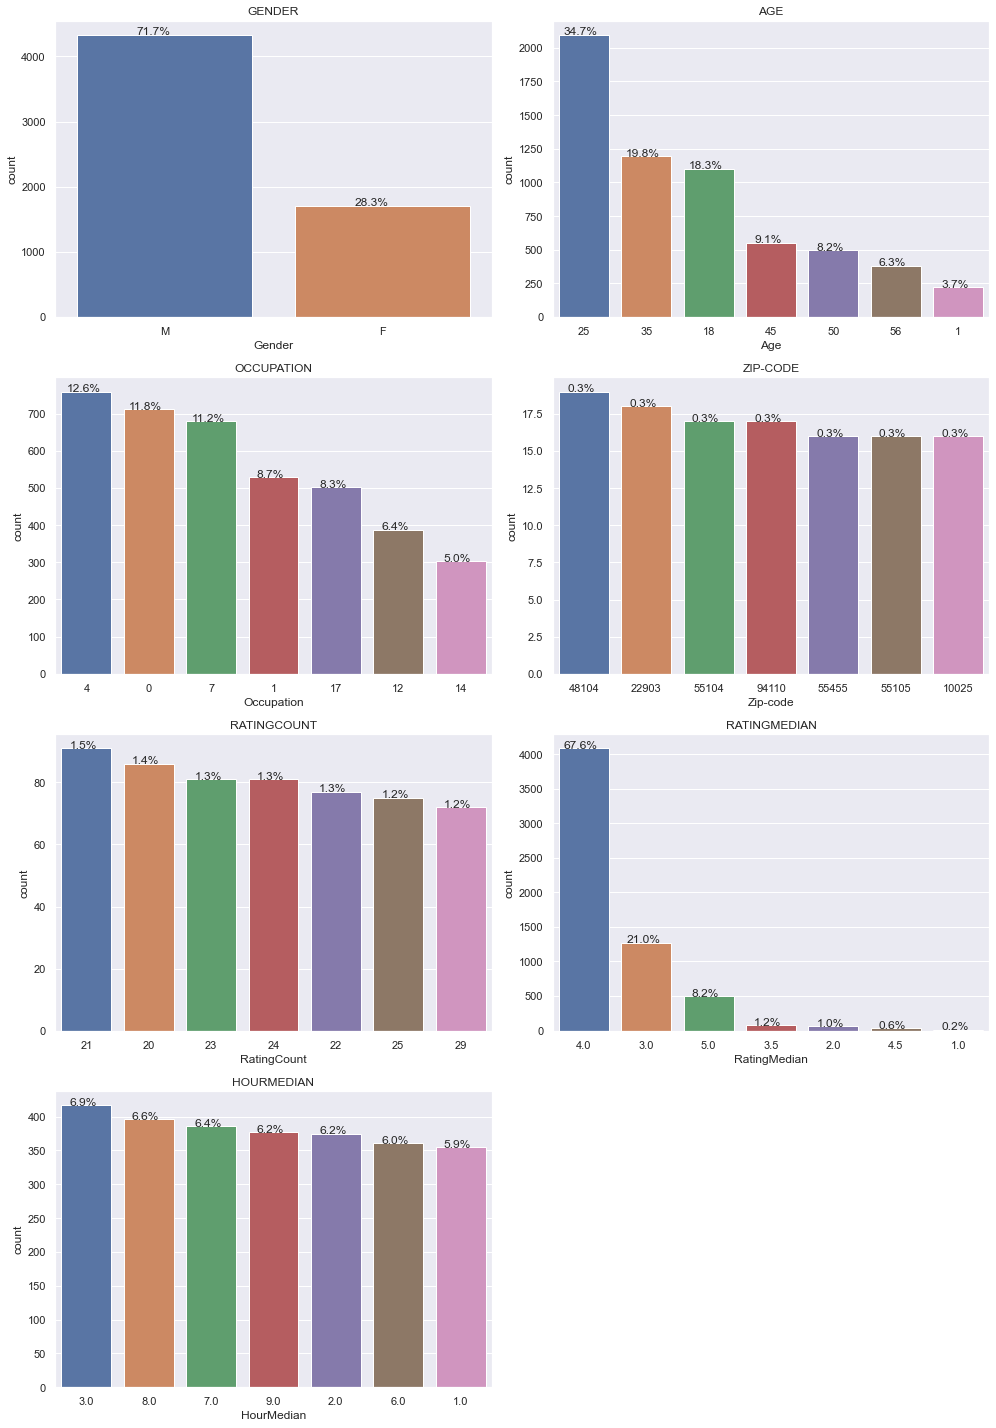

In [23]:
cat_cols = ['Gender', 'Age', 'Occupation', 'Zip-code', 'RatingCount','RatingMedian', 'HourMedian']

# Code snippet to create count plot for the categorical features:

cat_cols
title=['Gender','Age','Occupation', 'Zip-code', 'RatingCount', 'RatingMedian','HourMedian']

plt.figure(figsize=(14,20))
sns.set(style='darkgrid')

for i, variable in enumerate(cat_cols):
    plt.subplot(4,2,i+1)
    ax=sns.countplot(x=users[variable], data=users,  
                     order=users[variable].value_counts(ascending=False).iloc[:7].index)
    
    for p in ax.patches:
                           percentage = '{:.1f}%'.format(100 * p.get_height()/len(users[variable]))
                           x = p.get_x() + p.get_width() / 2 - 0.05
                           y = p.get_y() + p.get_height()
                           plt.annotate(percentage, (x, y),ha='center')
    plt.tight_layout()
    plt.title(title[i].upper())

***Key insights from users behaviour***
1. Male viewers largely outweigh the female viewers
2. More than 70% of the viewers belong to age group 25,35 and 18 (i.e age bracket of 18-24)
3. Region wise trend couldnot be observed the high level analysis
4. Most of the users view(or rate) 20-30 movies
5. ~88% of the content recieved 3 and 4 ratings, while ~8% got 5 rating
6. Since details like timezone are not provided, granularity could not be provided. However, traffic is higher in early morning and late night.
7. As evident from the age propotions, most of the viewers are graduate student and from other academic background. Also, most of the active users have higher exposure to technology



***Questionnaire:***
1. Users of which age group have watched and rated the most number of movies?

In [24]:
users.groupby(by='Age')['RatingCount'].sum().reset_index(name='Count').sort_values(by='Count',
                                                                                   ascending=False)[:3]

,Age,Count
2,25,395556
3,35,199003
1,18,183536


***Ans.***
group-25 (age: "25-34")

***Questionnaire:***\
2. Users belonging to which profession have watched and rated the most movies?\
***Ans. Occupation 4 - "college/grad student"***

In [25]:
users.groupby(by='Occupation')['RatingCount'].sum().reset_index(name='Count_Occupation').sort_values(by='Count_Occupation',
                                                                                                    ascending=False)[:3]

,Occupation,Count_Occupation
15,4,131032
0,0,130499
18,7,105425


***Questionnaire:***
    
3. Most of the users in our dataset who’ve rated the movies are Male. (T/F)
    
***Ans: T***

In [26]:
users.groupby(by='Gender')['RatingCount'].sum().reset_index(name='Count_Gender').sort_values(by='Count_Gender',
                                                                                                    ascending=False)[:3]

,Gender,Count_Gender
1,M,753769
0,F,246440


---
**Median count of movies seen by different age groups**

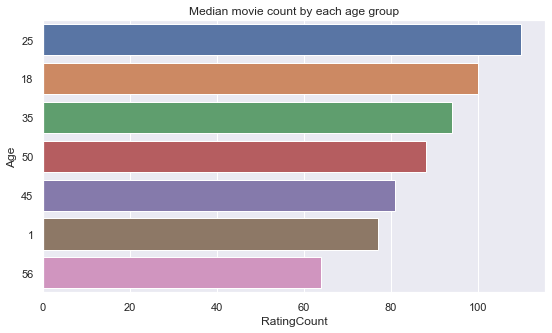

In [27]:
u1=users.copy()
u1 = u1.groupby(by='Age')['RatingCount'].median().reset_index().sort_values(by='RatingCount',
                                                                       ascending=False)

plt.figure(figsize=(9,5))
sns.barplot(data=u1, x='RatingCount', y='Age').set(title='Median movie count by each age group')
plt.show()

---
**Median count of movies seen by different Occupation**

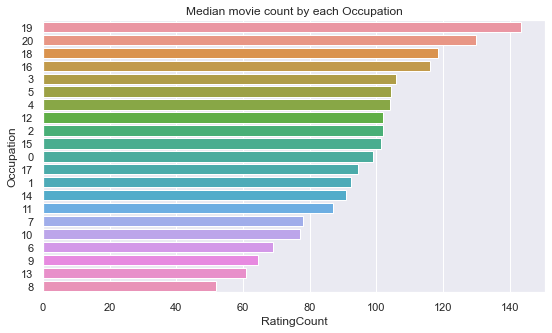

In [28]:
u2=users.copy()
u2 = u2.groupby(by='Occupation')['RatingCount'].median().reset_index().sort_values(by='RatingCount',
                                                                       ascending=False)


plt.figure(figsize=(9,5))
sns.barplot(data=u2, x='RatingCount', y='Occupation').set(title='Median movie count by each Occupation')
plt.show()

***Though the proportion of occupation no. 19( "unemployed"), 20("writer"), 18("tradesman/craftsman") is not high in the users list, such blue collar workers have high watch rate compared to the white collar workers!!!*** 

---
**Movies**

In [30]:
movies.head(3)

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


***'Movies' dataset needs preprocessing to extract Genre and release year***

In [31]:
m = movies.copy()
m['Genres'] = m['Genres'].str.split('|')
m = m.explode('Genres')
# m = m.pivot(index='MovieID', columns='Genres', values='Title')
m['Genres'] = m['Genres'].str.strip()
genre_list=m['Genres'].unique().tolist()

##### There are lot of redundant genres which needs correct mapping. 
##### So a mapping sheet is prepared manually and updated

In [32]:
path4=r'C:\Users\Alfred Paul\OneDrive\Desktop\Scaler_CaseStudies\JMJ_Zee\JMJ_Map2.csv'
genre_map=pd.read_csv(path4)

genre_map['Genres']=genre_map['Genres'].str.strip()
genre_map['Updated_Genre']=genre_map['Updated_Genre'].str.strip()

# Creating the dictionary
d=dict(genre_map.values)

# Mapping with the existing 'Genres'
m['Genres']=m['Genres'].map(d)

In [33]:
# Function to extract years from the movie title:

def findyear(year):
    for years in range(1500,2022):
        years=str(years)
        if(year.find(years)!=-1):
            return years

In [34]:
m['ReleaseYear']=m['Title'].apply(findyear)

# Dropping the null 'ReleaseYear'
m = m[m['ReleaseYear'].notna()]

# Finding movie age:
m['MovieAge']=m['ReleaseYear'].apply(lambda x:int(2022)-int(x))

m.head(3)

,MovieID,Title,Genres,ReleaseYear,MovieAge
0,1,Toy Story (1995),Animation,1995,27
0,1,Toy Story (1995),Children,1995,27
0,1,Toy Story (1995),Comedy,1995,27


---
**Median ReleaseYear across different genres**

In [35]:
m.groupby(by='Genres')['ReleaseYear'].median().head(3)

Genres
Action       1993.0
Adventure    1989.0
Animation    1992.5
Name: ReleaseYear, dtype: float64

**It can be observed that most of the movies across all genres were released pre 2000**

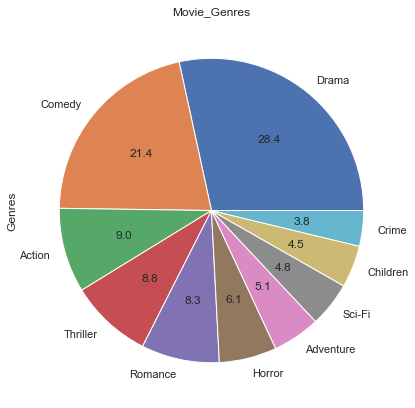

In [36]:
# Distribution of top 10 movie genres

plt.figure(figsize=(7,7))
m['Genres'].value_counts()[:10].plot(kind='pie', autopct='%.1f',title='Movie_Genres')
plt.show()

**Drama and comedy are the most popular genres**

---
**Preparing the overall dataset merging all the tables**

In [81]:
# Selecting the most rated movies
select_movies = ratings.MovieID.value_counts().head(1000).index.to_list()

# Extracting those popular movies
m2 = m.loc[m.MovieID.isin(select_movies)]
r2 = ratings.loc[ratings.MovieID.isin(select_movies)]


In [82]:
# Merging the rating details
comp_database = pd.merge(r2,m2,how='inner',on='MovieID')

u3=users.copy()

# Merging the user details
comp_database = pd.merge(comp_database,u3,how='inner',on='UserID')

# Fully merged dataset
comp_database.head(3)

,UserID,MovieID,Rating,Timestamp,Title,Genres,ReleaseYear,MovieAge,Gender,Age,Occupation,Zip-code,RatingCount,RatingMedian,HourMedian
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,1975,47,F,1,10,48067,53,4.0,4.0
1,1,661,3,978302109,James and the Giant Peach (1996),Animation,1996,26,F,1,10,48067,53,4.0,4.0
2,1,661,3,978302109,James and the Giant Peach (1996),Children,1996,26,F,1,10,48067,53,4.0,4.0


---
**Most rated genres**

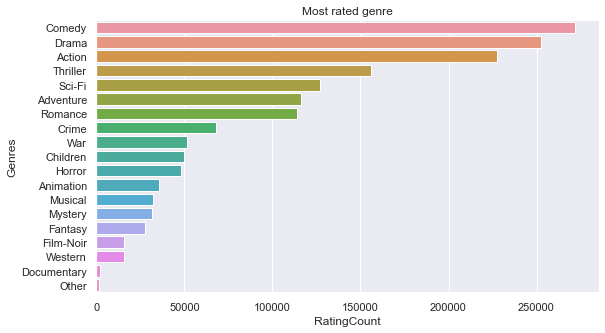

In [43]:
cd1 = comp_database.groupby(by='Genres').size().reset_index(name='RatingCount').sort_values(by='RatingCount',
                                                                                      ascending=False)

plt.figure(figsize=(9,5))
sns.barplot(data=cd1, x='RatingCount', y='Genres').set(title='Most rated genre')
plt.show()

---
**Most watched movies in each genre**

In [44]:
cd2=comp_database.groupby(by='Genres')['Title'].agg(pd.Series.mode).reset_index(name='MostViewed')
cd2[:5]

,Genres,MostViewed
0,Action,Star Wars: Episode IV - A New Hope (1977)
1,Adventure,Star Wars: Episode IV - A New Hope (1977)
2,Animation,Toy Story (1995)
3,Children,E.T. the Extra-Terrestrial (1982)
4,Comedy,American Beauty (1999)


---
**Most watched 'Genres' across different age groups**

In [83]:
cd3=comp_database.groupby(by='Age')['Genres'].agg(pd.Series.mode).reset_index(name='MostViewed_Genre')
cd3.head(4)

,Age,MostViewed_Genre
0,1,Comedy
1,18,Comedy
2,25,Comedy
3,35,Comedy


---
**Most watched 'Genres' across different 'Occupation'**

In [84]:
comp_database.groupby(by='Occupation')['Genres'].agg(pd.Series.mode).reset_index(name='MostViewed_Genre').head(4)

,Occupation,MostViewed_Genre
0,0,Comedy
1,1,Drama
2,10,Comedy
3,11,Comedy


***Further preprocessing the 'movies' dataset***

In [47]:
m2 = m2.pivot(index='MovieID', columns='Genres', values='Title')
m2 = ~m2.isna()
m2 = m2.astype(int)
m2.head(3)

Genres,NaN,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Other,Romance,Sci-Fi,Thriller,War,Western
MovieID,,,,,,,,,,,,,,,,,,,,
1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1019,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [48]:
# Creating the dataframe with the age of each movie corresponding 
# to the 'MovieID'
m_ref=m.drop(columns=['Title','Genres','ReleaseYear'])
m_ref = m_ref.groupby(by='MovieID').agg({'MovieAge':'first'}).reset_index()

# Merging the age with the initial dataset
m2 = pd.merge(m2,m_ref,how='inner',on='MovieID')

m2=m2.set_index('MovieID')

# Scaling the dataset
scaler=StandardScaler()
m_item_rec = pd.DataFrame(scaler.fit_transform(m2), columns=m2.columns, index=m2.index)
m_item_rec.head(3)

C:\Users\Alfred Paul\Anaconda2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Alfred Paul\Anaconda2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(


,NaN,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,Musical,Mystery,Other,Romance,Sci-Fi,Thriller,War,Western,MovieAge
MovieID,,,,,,,,,,,,,,,,,,,,,
1,-0.044811,-0.593552,-0.387001,4.354308,3.613356,1.337053,-0.299198,-0.05491,-0.718831,-0.184924,...,-0.268264,-0.219817,-0.2173,-0.05491,-0.430434,-0.412296,-0.494357,-0.250665,-0.150137,-0.591750
10,-0.044811,1.684773,2.583974,-0.229658,-0.276751,-0.747914,-0.299198,-0.05491,-0.718831,-0.184924,...,-0.268264,-0.219817,-0.2173,-0.05491,-0.430434,-0.412296,2.022829,-0.250665,-0.150137,-0.591750
1019,-0.044811,-0.593552,2.583974,-0.229658,3.613356,-0.747914,-0.299198,-0.05491,-0.718831,5.407626,...,-0.268264,-0.219817,-0.2173,-0.05491,-0.430434,-0.412296,-0.494357,-0.250665,-0.150137,2.305956


---
**Item based Recommender System based on Pearson Correlation**

In [49]:
# Function to calculate the pearson correlation

def pearson(x,y):
    r, p = scipy.stats.pearsonr(x, y)
    return r

In [50]:
# Creaing a dataset which computes pearson correlation coefficient of 
# each movie with remaining all other movies

# %%time

ranks = []

for query in m_item_rec.index:
    for candidate in m_item_rec.index:
        if candidate == query:
            continue
        ranks.append([query, candidate, pearson(m_item_rec.loc[query], m_item_rec.loc[candidate])])

# Creating a dataset using the existing matrix        
ranks = pd.DataFrame(ranks, columns=['query', 'candidate', 'distance'])

# Merging with movies dataset to get title for query and candidate
ranks = ranks.merge(movies[['MovieID', 'Title']], left_on='query', right_on='MovieID').rename(columns={'Title': 'query_tittle'}).drop(columns=['MovieID'])
ranks = ranks.merge(movies[['MovieID', 'Title']], left_on='candidate', right_on='MovieID').rename(columns={'Title': 'candidate_tittle'}).drop(columns=['MovieID'])

# Sorting the ranks based on query and distance
ranks = ranks.sort_values(by=['query', 'distance'],ascending=[True,False])

In [51]:
# Checking the 5 closest movies to query=1(Toy Story (1995))

ranks.loc[ranks['query']=='1'].head(5)

,query,candidate,distance,query_tittle,candidate_tittle
434692,1,2355,0.999413,Toy Story (1995),"Bug's Life, A (1998)"
662008,1,3114,0.998961,Toy Story (1995),Toy Story 2 (1999)
830501,1,3751,0.998383,Toy Story (1995),Chicken Run (2000)
379857,1,2141,0.994561,Toy Story (1995),"American Tail, An (1986)"
291124,1,1907,0.941385,Toy Story (1995),Mulan (1998)



**Questionnaire:** \
**6. Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.**

In [52]:
movies[movies['Title']=='Liar Liar (1997)']

,MovieID,Title,Genres
1455,1485,Liar Liar (1997),Comedy


In [53]:
ranks.loc[ranks['query']=='1485'].head(5)

,query,candidate,distance,query_tittle,candidate_tittle
199596,1485,1513,1.000000,Liar Liar (1997),Romy and Michele's High School Reunion (1997)
200593,1485,1517,1.000000,Liar Liar (1997),Austin Powers: International Man of Mystery (1...
226515,1485,1614,1.000000,Liar Liar (1997),In & Out (1997)
237482,1485,1641,1.000000,Liar Liar (1997),"Full Monty, The (1997)"
285338,1485,1883,0.999364,Liar Liar (1997),Bulworth (1998)


---

---

***Item similarity matrix using cosine distance***

In [55]:
# Creaing the similarity matrix
cs=cosine_similarity(m_item_rec,m_item_rec)

# Extracting the movie id & storing it to list
col=m_item_rec.index.to_list()

# Creating the dataframe using the similarity matrix
cs_item = pd.DataFrame(cs,columns=col)

# Setting the index as movie-id
cs_item.index=col
cs_item.head(3)

,1,10,1019,1020,1022,1027,1028,1029,1030,1031,...,933,940,95,951,953,954,955,968,969,994
1,1.000000,-0.182241,0.210346,0.169643,0.643409,-0.186950,0.364098,0.617301,0.641480,0.256091,...,-0.076119,-0.188944,-0.171802,-0.006045,-0.198191,-0.189691,-0.009364,-0.135754,-0.191838,-0.163523
10,-0.182241,1.000000,0.105340,-0.286669,-0.182921,-0.288840,-0.224163,-0.189337,0.097251,0.145813,...,-0.000639,0.436321,0.674390,-0.296064,-0.302858,-0.289612,-0.292263,-0.207584,0.270107,-0.253258
1019,0.210346,0.105340,1.000000,-0.205286,0.293064,-0.179457,0.305706,0.308723,0.347520,0.453507,...,0.019279,0.374891,-0.201467,0.189461,0.171902,0.192309,0.194551,0.006627,0.198077,-0.223193


---
***User similarity matrix using cosine distance***


***Encoding the categorical features***

In [56]:
# Creating a copy of the user dataset
user_c_sim=users.copy()

# Creating the mapping, based on the movies watched
# 1.Gender
map_gender = user_c_sim.groupby(by='Gender').median()['RatingCount'].to_dict()

# 2. Occupation
map_occupation= user_c_sim.groupby(by='Occupation').median()['RatingCount'].to_dict()

# 3. Zip code
map_zip= user_c_sim.groupby(by='Zip-code').median()['RatingCount'].to_dict()

# Applying the mapping 
user_c_sim['Gender']=user_c_sim['Gender'].map(map_gender)
user_c_sim['Occupation']=user_c_sim['Occupation'].map(map_occupation)
user_c_sim['Zip-code']=user_c_sim['Zip-code'].map(map_zip)

user_c_sim=user_c_sim.set_index('UserID')

# Scaling the data
user_c_sim = pd.DataFrame(scaler.fit_transform(user_c_sim), columns=user_c_sim.columns, 
                          index=user_c_sim.index)

user_c_sim.head(3)


,Gender,Age,Occupation,Zip-code,RatingCount,RatingMedian,HourMedian
UserID,,,,,,,
1,-1.591927,-2.298525,-1.187683,-0.061192,-0.584221,0.275699,-0.772415
2,0.628170,1.966729,1.276150,-0.115731,-0.189889,0.275699,-0.912095
3,0.628170,-0.437323,0.360109,-0.402063,-0.594598,0.275699,-1.051775


In [57]:
# Creaing the similarity matrix
cs_user=cosine_similarity(user_c_sim)

# Extracting the UserID & storing it to list
col_user=user_c_sim.index.to_list()

# Creating the dataframe using the similarity matrix
cs_user = pd.DataFrame(cs_user,columns=col_user)

# Setting the index as UserID
cs_user.index=col_user
cs_user.head(3)

,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
1,1.000000,-0.732713,0.168517,-0.109574,-0.372656,0.182318,-0.290367,-0.045038,0.228346,0.235402,...,0.768128,-0.316420,-0.127886,0.296624,0.237920,0.035108,0.066652,-0.074062,0.065526,0.269167
2,-0.732713,1.000000,0.292443,0.423116,0.219134,-0.052294,0.372008,0.137096,0.002069,-0.086737,...,-0.401391,0.308762,0.143885,-0.033979,-0.279676,-0.200987,0.231664,0.465913,0.395399,-0.416681
3,0.168517,0.292443,1.000000,0.383122,0.152107,-0.405417,0.397158,0.773681,0.834401,-0.505218,...,0.127265,-0.044744,-0.046275,0.820352,-0.333696,-0.522589,-0.433562,-0.089573,-0.146064,0.014870


---
***Item-based recommender system with Nearest Neighbors algorithm and Cosine Similarity***


In [58]:
# Defining the model and initialising

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute',n_neighbors=5,n_jobs=-1)
model_knn.fit(m_item_rec)

C:\Users\Alfred Paul\Anaconda2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(


NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1)

In [59]:
# Function to calclulate the NearestNeighbors

def NNeighbors(x):
    distances, indices = model_knn.kneighbors(x)
    return distances,indices

In [60]:
# Testing the recommender system with movie id=1

dis,ind=NNeighbors(m_item_rec.loc['1'].values.reshape(1,-1))

In [61]:
# result is calculated using the indices and distances

ind=ind.flatten()
dis=dis.flatten()

Neigh_5=[]
for i in range(0, len(dis)):
    Neigh_5.append([m_item_rec.index[ind[0]],m_item_rec.index[ind[i]], dis[i]])
    
# Creating a dataset using the existing matrix        
Neigh_5 = pd.DataFrame(Neigh_5, columns=['query_id', 'candidate_id', 'distance'])

# Merging with movies dataset to get title for query and candidate
Neigh_5 = Neigh_5.merge(movies[['MovieID', 'Title']], 
                        left_on='query_id', right_on='MovieID').rename(columns={'Title': 'query_tittle'}).drop(columns=['MovieID'])

Neigh_5 = Neigh_5.merge(movies[['MovieID', 'Title']], 
                        left_on='candidate_id', right_on='MovieID').rename(columns={'Title': 'candidate_tittle'}).drop(columns=['MovieID'])
Neigh_5
    


,query_id,candidate_id,distance,query_tittle,candidate_tittle
0,1,1,0.000000,Toy Story (1995),Toy Story (1995)
1,1,2355,0.000611,Toy Story (1995),"Bug's Life, A (1998)"
2,1,3114,0.001082,Toy Story (1995),Toy Story 2 (1999)
3,1,3751,0.001685,Toy Story (1995),Chicken Run (2000)
4,1,2141,0.005607,Toy Story (1995),"American Tail, An (1986)"


---
**Recommender System based on Matrix Factorization**

In [62]:
# Rating matrix created manually

ratings['Rating']=ratings['Rating'].astype(int)

rm = ratings.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
rm.head(3)

MovieID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:

# Creating specific matrix for Matrix Factorisation
rm_raw = ratings[['UserID', 'MovieID', 'Rating']].copy()
rm_raw.columns = ['UserId', 'ItemId', 'Rating'] 
rm_raw.head(3)

,UserId,ItemId,Rating
0,1,1193,5
1,1,661,3
2,1,914,3


In [64]:
rm_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   UserId  1000209 non-null  object
 1   ItemId  1000209 non-null  object
 2   Rating  1000209 non-null  int32 
dtypes: int32(1), object(2)
memory usage: 19.1+ MB


In [65]:
# Defining the model:

# %%time
model = CMF(method="als", k=4, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)
model.fit(rm_raw)

Collective matrix factorization model
(explicit-feedback variant)


In [66]:
# model.A_---> compressed user matrix
# model.B_---> compressed movies matrix

model.A_.shape, model.B_.shape

((6040, 4), (3706, 4))

In [67]:
# Checking the mean rating of the model:

model.glob_mean_

3.581564426422119

In [68]:
# Predicted rating matrix using user and movie matrix

rm__ = np.dot(model.A_, model.B_.T) + model.glob_mean_


**Performance of Matrix Factorisation model**

In [69]:
# 1. RMSE

mse(rm.values[rm > 0], rm__[rm > 0])**0.5

1.4183051023119877

In [70]:
# 2. MAPE

y_actual = rm.values[rm > 0]
y_pred = rm__[rm > 0]

mean_absolute_percentage_error(y_actual, y_pred)

0.41151259136274926

In [71]:
# Recommending 10 movies for the user_id = 1

top_items = model.topN(user=1, n=10)
movies.loc[movies.MovieID.isin(top_items)]

,MovieID,Title,Genres
52,53,Lamerica (1994),Drama
664,670,"World of Apu, The (Apur Sansar) (1959)",Drama
910,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Film-Noir
911,923,Citizen Kane (1941),Drama
1950,2019,Seven Samurai (The Magnificent Seven) (Shichin...,None
2770,2839,West Beirut (West Beyrouth) (1998),Drama
3176,3245,I Am Cuba (Soy Cuba/Ya Kuba) (1964),Drama
3739,3808,Two Women (La Ciociara) (1961),Drama|War
3747,3817,"Other Side of Sunday, The (Søndagsengler) (1996)",Comedy|Drama
3835,3905,"Specials, The (2000)",Comedy


In [87]:
# Creating dataset using user embeded matrix

user_embeded = pd.DataFrame(data=model.A_,index=user_c_sim.index)

# Creating a sample 
user_embeded_sample = user_embeded.sample(frac=0.07)

user_embeded_sample.head(3)

,0,1,2,3
UserID,,,,
3690,0.176815,0.054053,-0.288413,0.097726
1760,-0.066431,-0.167836,-0.075958,-0.057512
97,0.075637,-0.257563,-0.077175,-0.188694


---
**User embeddings for similarity based models**

In [73]:
# Creaing a dataset which computes pearson correlation coefficient of 
# each user with remaining all other user from the user compressed matrix

# %%time

ranks_user_emb = []

for query in user_embeded_sample.index:
    for candidate in user_embeded_sample.index:
        if candidate == query:
            continue
        ranks_user_emb.append([query, candidate, pearson(user_embeded_sample.loc[query], user_embeded_sample.loc[candidate])])

# Creating a dataset using the existing matrix        
ranks_user_emb = pd.DataFrame(ranks_user_emb, columns=['query', 'candidate', 'distance'])

# Merging with movies dataset to get title for query and candidate
ranks_user_emb = ranks_user_emb.merge(users[['UserID', 'Age']], left_on='query', right_on='UserID').rename(columns={'Age': 'query_age'}).drop(columns=['UserID'])
ranks_user_emb = ranks_user_emb.merge(users[['UserID', 'Age']], left_on='candidate', right_on='UserID').rename(columns={'Age': 'candidate_age'}).drop(columns=['UserID'])

# Sorting the ranks_user_emb based on query and distance
ranks_user_emb = ranks_user_emb.sort_values(by=['query', 'distance'],ascending=[True,False])
ranks_user_emb.head(3)

,query,candidate,distance,query_age,candidate_age
44780,1014,2840,0.998966,45,25
16927,1014,3312,0.998847,45,18
26634,1014,587,0.996584,45,25


***[Optional] User-based approach to create a recommender system using Pearson Correlation***

In [74]:
# Creating a sample dataset

users_sample=user_c_sim.sample(frac=0.07)

In [75]:
# Creaing a dataset which computes pearson correlation coefficient of 
# each user with remaining all other user

# %%time

ranks_user_sample = []

for query in users_sample.index:
    for candidate in users_sample.index:
        if candidate == query:
            continue
        ranks_user_sample.append([query, candidate, pearson(users_sample.loc[query], users_sample.loc[candidate])])

# Creating a dataset using the existing matrix        
ranks_user_sample = pd.DataFrame(ranks_user_sample, columns=['query', 'candidate', 'distance'])

# Merging with movies dataset to get title for query and candidate
ranks_user_sample = ranks_user_sample.merge(users[['UserID', 'Age']], left_on='query', right_on='UserID').rename(columns={'Age': 'query_age'}).drop(columns=['UserID'])
ranks_user_sample = ranks_user_sample.merge(users[['UserID', 'Age']], left_on='candidate', right_on='UserID').rename(columns={'Age': 'candidate_age'}).drop(columns=['UserID'])

# Sorting the ranks_user_emb based on query and distance
ranks_user_sample = ranks_user_sample.sort_values(by=['query', 'distance'],ascending=[True,False])
ranks_user_sample.head(3)

,query,candidate,distance,query_age,candidate_age
29398,1003,815,0.983686,25,25
175411,1003,5836,0.974031,25,25
124349,1003,747,0.947382,25,18


---
**Questionnaire**

**4. Most of the movies present on our dataset were released in which decade?
a. 70s b. 90s c. 50s d.80s**\
**Ans. b (90s)**

In [76]:
m.groupby(by='ReleaseYear').size().reset_index(name='Year_wise_count').sort_values(by='Year_wise_count',
                                                                                   ascending=False).head(3)

,ReleaseYear,Year_wise_count
80,1998,566
77,1995,542
78,1996,539


**5. The movie with maximum no. of ratings is ___.**\
**Ans. American Beauty (1999)**

In [77]:
ratings.groupby(by='MovieID').size().reset_index(name='Rating_count').sort_values(by='Rating_count',
                                                                                  ascending=False).head(3)


,MovieID,Rating_count
1916,2858,3428
1640,260,2991
191,1196,2990


In [78]:
movies[movies['MovieID']=='2858']

,MovieID,Title,Genres
2789,2858,American Beauty (1999),Comedy|Drama


**6. Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.**\
Answer (Coding part done in item similarity section with pearson correlation)

1. Romy and Michele's High School Reunion (1997)
2. Austin Powers: International Man of Mystery (1997)
3. In & Out (1997)
4. Full Monty, The (1997)
5. Bulworth (1998)

**7. On the basis of approach, Collaborative Filtering methods can be classified into
___-based and ___-based**\

Answer:
1. User-based
2. Item-based

**8.Pearson Correlation ranges between ___ to ___ whereas, Cosine Similarity belongs
to the interval between ___ to ___.**
 
Answer:
1. -1 to +1
2. 0 to 1

**9. Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization
model.**

Answer:

    1. RMSE: 1.418
    2. MAPE: 0.411


**10. Give the sparse ‘row’ matrix representation for the following dense matrix -
[[1 0]
3 7]]**


In [79]:
from scipy.sparse import csr_matrix

In [80]:
data=np.array([[1,0],[3,7]])
sparseMatrix = csr_matrix(data,shape=(2,2))
sparseMatrix.toarray()

array([[1, 0],
       [3, 7]], dtype=int32)

---
**Insights & Recommendations**

1. Since most of the viewers are male, more strategies like better promotions and content design should be in place to bring more female viewers

2. Similar approach should be in place for attractin more senior audience. Adding more content in regional languages might help

3. Though count in terms of registration is high for students and white collar job holders, watch rate is higher for unemployed and blue collar job holders. So, by adding more flexibility in terms of pricing (for example, adding plans for shorter days, or budget friendly packs in regional languages) and other related features can help a lot

4. Viewers mostly enjoy or watch comedy and drama based content. So, adding more of such content or giving more flavour in genre by using collaborative filtering can improve the user participation in the platform

5. 'Comedy' based content dominate the genre with respect to factors such as gender, age and occupation

6. Recommending 'Comedy' based content can be considered as a default choice and it can yield high watch rate

7. Most of the movies given in the database have release year pre 2000. Adding latest content can improve the participation particularly of the young viewers.


---
**JMJ+**